In [72]:
# prerequisites
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

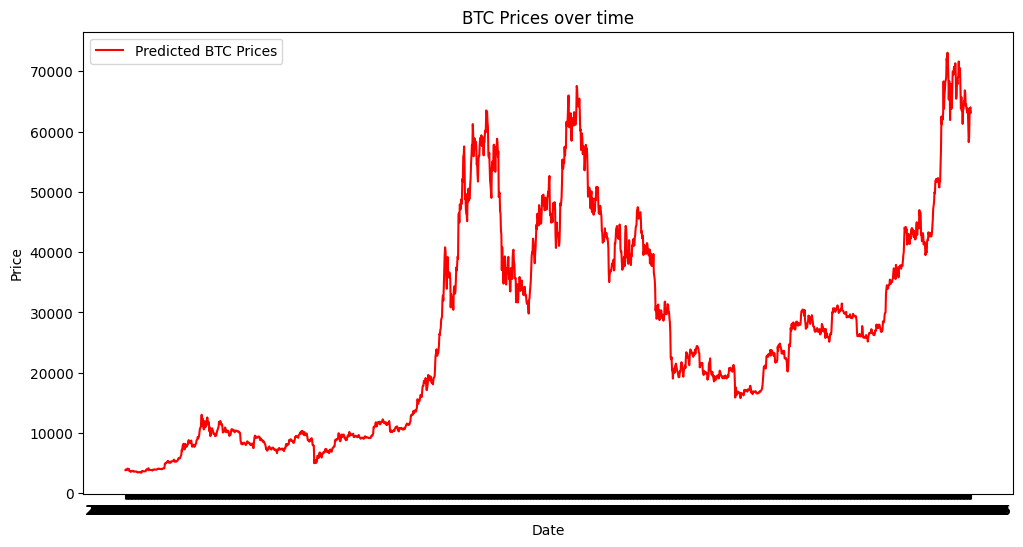

,Open,High,Low,Close,Adj Close,Volume
count,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1.953000e+03
mean,26664.763810,27271.087203,26018.424934,26693.141439,26693.141439,2.935099e+10
std,17667.274636,18108.503737,17161.292543,17675.687087,17675.687087,1.807680e+10
min,3401.376465,3427.945557,3391.023682,3399.471680,3399.471680,4.324201e+09
25%,10024.115234,10191.675781,9729.334961,10051.704102,10051.704102,1.735319e+10
50%,23733.570312,24203.689453,23243.353516,23774.566406,23774.566406,2.592181e+10
75%,39907.261719,40846.546875,38777.035156,39935.515625,39935.515625,3.670859e+10
max,73079.375000,73750.070312,71334.093750,73083.500000,73083.500000,3.509679e+11


In [64]:
# Load the dataset
df = pd.read_csv('data/BTC-USD.csv')

# Convert 'Date' to datetime format
df_dates = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

plt.figure(figsize=(12,6))
plt.plot(df.index,df["Close"], color='red', label='Predicted BTC Prices')
plt.title('BTC Prices over time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

df.describe()

In [66]:
# Prepare the data
df = df.drop(labels={"Open", "High", "Low", "Adj Close", "Volume"}, axis=1)
df = df.rename(columns={'Close': 'closing_price'})
df.head()

,closing_price
Date,
2019-01-01,3843.520020
2019-01-02,3943.409424
2019-01-03,3836.741211
2019-01-04,3857.717529
2019-01-05,3845.194580


In [67]:
# check for missing values
print(df.isnull().sum())

closing_price    0
dtype: int64


In [68]:
# Scale the data
scaler = MinMaxScaler()
df['closing_price'] = scaler.fit_transform(df[['closing_price']])

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

print("training set:", train_data.describe(),  "\ntesting set:", test_data.describe())


training set:        closing_price
count    1562.000000
mean        0.288814
std         0.243970
min         0.000000
25%         0.084232
50%         0.225132
75%         0.490300
max         0.920833 
testing set:        closing_price
count     391.000000
mean        0.515890
std         0.206031
min         0.311767
25%         0.348938
50%         0.437719
75%         0.585000
max         1.000000


In [69]:
import numpy as np

# Time series window
def create_dataset(data, window_size, shuffle=False):
    x, y = [], []

    for i in range(window_size, len(data)):
        x.append(data.iloc[i - window_size:i].values)
        y.append(data.iloc[i].values)

    x, y = np.array(x), np.array(y)

    if shuffle:
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x, y = x[indices], y[indices]

    return x, y

# Usage
window_size = 50
x_train, y_train = create_dataset(train_data, window_size, shuffle=True)
x_test, y_test = create_dataset(test_data, window_size, shuffle=False)

# Reshape the data for the LSTM model
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


In [78]:
# setup early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# model checkpoint
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint])
predictions = model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(real_prices, predicted_prices)

# Print metrics
print(f'MAE: {mae}, RMSE: {rmse}, R-squared: {r2}')

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0295 - val_loss: 0.0014
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0019 - val_loss: 8.0963e-04
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0015 - val_loss: 7.6463e-04
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0018 - val_loss: 7.3028e-04
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0016 - val_loss: 7.2481e-04
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0014 - val_loss: 8.7401e-04
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 50, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,905 (1.39 MB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 242,604 (947.68 KB)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


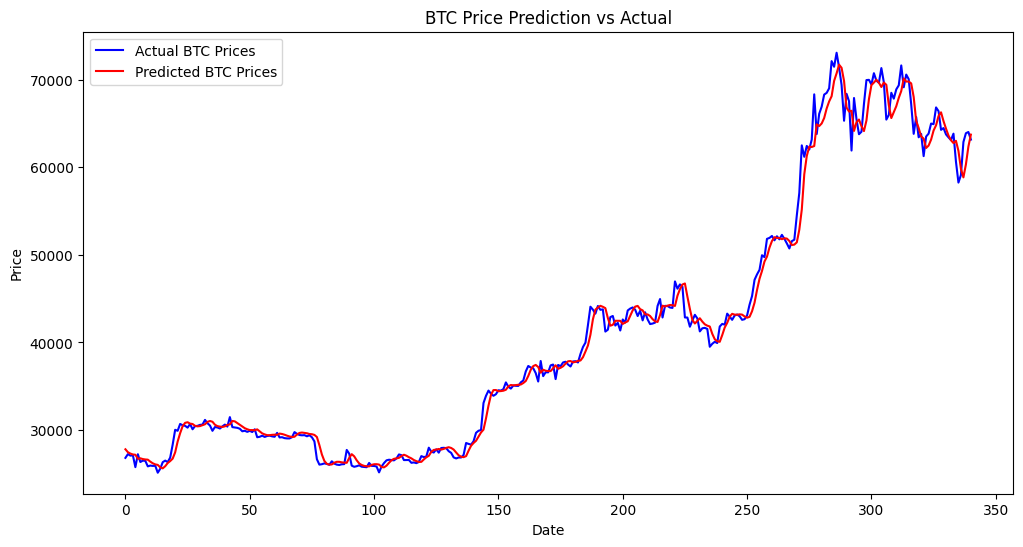

In [81]:
# Model summary
model.summary()
# Make predictions

predictions = model.predict(x_test)

# Inverse the scaling to get the real prices
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(12,6))
plt.plot(real_prices, color='blue', label='Actual BTC Prices')
plt.plot(predicted_prices, color='red', label='Predicted BTC Prices')
plt.title('BTC Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
